## Extrapolating Odor/Odorless calculations to GDB

This notebook describes some sanity checks for specific functional groups and computations for extrapolating the odor/odorless model to GDB-17.

In [ ]:
import collections
import functools
import os

from typing import Iterable, Iterator, Optional

import altair as alt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import Crippen
from rdkit.Chem import Descriptors
from rdkit.Chem import rdMolDescriptors
import seaborn as sns
import sklearn.ensemble
import sklearn.metrics
import sklearn.model_selection
import tqdm

In [ ]:
def load_csv(filename):
  return pd.read_csv(filename, encoding='utf-8')

## Load data


In [ ]:
all_df = load_csv('data/AllTransportData.csv')
# Remove hypervalent halogen compounds, which throws validation errors.
def _is_valid_smiles(smiles: str) -> bool:
  """Check if smiles string is legal, first syntax than chemistry.

  Currently, all sanitization routines are applied. See rdkit documentation:
  https://www.rdkit.org/docs/source/rdkit.Chem.rdmolops.html#rdkit.Chem.rdmolops.SanitizeFlags

  Args:
    smiles: The SMILES string (possibly illegal)

  Returns:
    Whether smiles is valid and passes sanitization checks.
  """
  # Pandas generates NaN (technically a "float") for empty rows.
  if not isinstance(smiles, (bytes, str)):
    return False
  mol = Chem.MolFromSmiles(smiles, sanitize=False)
  if mol is None:
    return False
  try:
    Chem.SanitizeMol(mol)
    return True
  except ValueError:
    return False
clean_df = all_df[all_df['SMILES'].apply(_is_valid_smiles)]
clean_df = clean_df.set_index('SMILES')
print("{} entries in the raw data".format(len(clean_df)))
print("{} / {} entries are odorous".format(sum(clean_df['odor'] == 'Odor'), len(clean_df)))
print(clean_df.groupby('dataset.assigned')['odor'].count())

1924 entries in the raw data
1615 / 1924 entries are odorous
dataset.assigned
test            30
train         1864
validation      30
Name: odor, dtype: int64


In [ ]:
duplicated_smiles_mask = all_df.duplicated('SMILES', keep=False)
assert sum(duplicated_smiles_mask) == 0, 'Duplicated SMILES found!'
clean_df['mols'] = [Chem.MolFromSmiles(s) for s in clean_df.index]
clean_df['crippen_logp'] = [Crippen.MolLogP(m) for m in clean_df['mols']]

(-52.515754780300014, 1191.7129452196998, -52.55285, 1191.6758499999999)

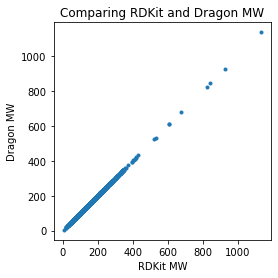

In [ ]:
# Is our molecular weight calculation the same as dragon?
mw = [Descriptors.ExactMolWt(m) for m in clean_df['mols']]
plt.plot(mw, clean_df.MW, '.')
plt.xlabel('RDKit MW')
plt.ylabel('Dragon MW')
plt.title('Comparing RDKit and Dragon MW')
plt.axis('square');
# Yes it is.

(-50.0, 1000.0)

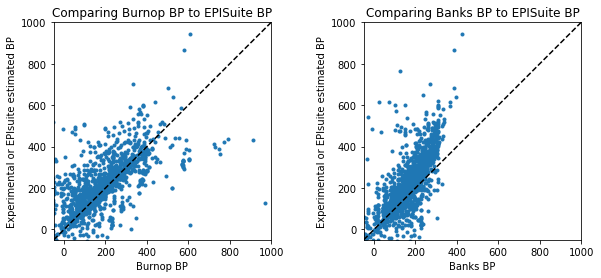

In [ ]:
LIMITS = [-50, 1000]
# Does our Burnop BP calculation match the experimental/estimated BP?
plt.figure(figsize=(10,4))
gs = plt.GridSpec(1, 2, wspace=0.25)
plt.subplot(gs[0])
plt.plot(clean_df['boiling.point.estimate.Burnop'], clean_df.BPbest, '.')
plt.plot(LIMITS, LIMITS, '--k')
plt.xlabel('Burnop BP')
plt.ylabel('Experimental or EPIsuite estimated BP')
plt.title('Comparing Burnop BP to EPISuite BP')
plt.axis('square')
plt.xlim(*LIMITS)
plt.ylim(*LIMITS)

# Banks BP seems to systematically underestimate the EPISuite BP, though. What's that about?
plt.subplot(gs[1])
plt.plot(clean_df['boiling.point.estimate.Banks'], clean_df.BPbest, '.')
plt.plot(LIMITS, LIMITS, '--k')
plt.xlabel('Banks BP')
plt.ylabel('Experimental or EPIsuite estimated BP')
plt.title('Comparing Banks BP to EPISuite BP')
plt.axis('square');
plt.xlim(*LIMITS)
plt.ylim(*LIMITS)


(-10.0, 10.0)

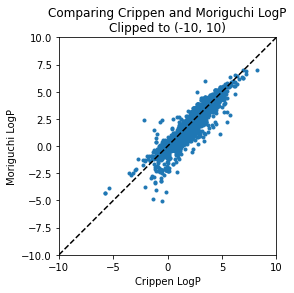

In [ ]:
# How does Crippen LogP match onto MLOGP?
plt.plot(clean_df.crippen_logp, clean_df.MLOGP, '.')
plt.plot([-10, 10], [-10, 10], '--k')
plt.xlabel('Crippen LogP')
plt.ylabel('Moriguchi LogP')
plt.title('Comparing Crippen and Moriguchi LogP\nClipped to (-10, 10)');
plt.axis('square')
plt.xlim(-10, 10)
plt.ylim(-10, 10)

In [ ]:
def rule_of_three_score(train_x, train_y, test_x, bp_to_use):
  """Rule of 3: 30 < MW < 300; numHeteroatoms < 3.

  The mw/heteroatam balance is chosen so that a maximum score is obtained when
  MW = avg(30, 300) and numHetAtoms = 0
  and also that a score of precisely 0 is obtained when
  (MW = avg(30, 300) and numHetAtoms = 3)  OR (MW = 30 and numHetAtoms = 0) OR (MW = 300 and numHetAtoms = 0)
  """
  mw_score = np.minimum(test_x['MW'] - 30, 300 - test_x['MW'])
  heteroatom_score = np.array([rdMolDescriptors.CalcNumHeteroatoms(mol) for mol in test_x['mols']]) * -(30 + 300) / 2 / 3
  return (mw_score + heteroatom_score).to_numpy()


# Domains of Validity for odor/odorless models

Different models might have different weaknesses. Can we draw any conclusions
about the performance of some models on various input classes?

In [ ]:
fragment_queries = {
  'Benzene': ('c1ccccc1', False),
  'Ester': ('[CX3](=O)O[#6]', False),
  'Carboxylic Acid': ('[CX3](=O)[OX2H1]', False),
  'Aldehyde or ketone': ('[$([#6][CX3](=O)[#6]),$([#6][CX3H1](=O))]', False),
  'Alkyl (4+ carbon chain)': ('[CH2X4][CH2X4][CH2X4][CH2X4]', False),
  'Amine': ('[NX3;H2,H1,H0;!$(NC=O);!$(NO)]', False),
  'Organohalide': ('[#6][#9,#17,#35,#53]', False),
  'Hydroxyl': ('[C;!$(C=O)][OX2H]', False),
  'Ether': ('[!$(C=O);$([C&!a])][OX2&H0][!$(C=O);#6]', False),
  'Inorganic': ('[#6]', True),
  'Organosulfide': ('[SX2][#6]', False),
}
# The following fragments were tested but excluded from analysis due to tiny sample sizes or lack of odorous molecules.
#  'Phosphate': '[$(P(~O)(~O)~O)]',
#  'Nitro': '[NX3;$(N(~O)~O)]',
#  'Organosulfide': '[SX2][#6]',
#  'Metal-containing': '[Li,Na,K,Rb,Cs,Be,Mg,Ca,Sr,Ba,Sc,Ti,V,Cr,Mn,Fe,Co,Ni,Cu,Zn,Y,Zr,Nb,Mo,Tc,Ru,Rh,Pd,Ag,Al,Ta,Tl,Sn,Pb,Os,Hg,U]'

## Construct an ensemble of random train-test splits

This step is needed for narrower CIs on our AUROC measurements. Otherwise, each test slice has too few molecules to give a reliable AUROC metric.

In [ ]:
# Code to create splits from scratch.
# Has random seed so it should be somewhat reproducible.
NUM_SPLITS = 80
splits_array = np.zeros(shape=(NUM_SPLITS, len(clean_df))) # Array indicating which molecules are in which splits.
for random_seed in range(NUM_SPLITS):
  train_ids, test_ids = sklearn.model_selection.train_test_split(
      np.arange(len(clean_df)), test_size=0.2, random_state=random_seed)
  train_ids.sort(); test_ids.sort()
  train_x, test_x = clean_df.iloc[train_ids], clean_df.iloc[test_ids]
  train_y = clean_df.iloc[train_ids]['odor'] == 'Odor'
  splits_array[random_seed, train_ids] = 1

assert splits_array.shape[0] == NUM_SPLITS
splits_df = pd.DataFrame({
    **{'split_{}'.format(i): splits_array[i]
       for i in range(80)}}, index=clean_df.index)


In [ ]:
# Here's the actual splits we used, for full reproducibility.
reconstructed_split_data = load_csv('data/Validity_XGB_all.csv').set_index('SMILES')
splits_df = reconstructed_split_data.isna().astype(int)
assert len(splits_df.columns) == NUM_SPLITS

In [ ]:
def run_model_predictions(model, bp_to_use):
  results_df = pd.DataFrame(index=splits_df.index, columns=splits_df.columns)
  for split_column in tqdm.tqdm(splits_df.columns):
    train_smiles = splits_df.index[splits_df[split_column] == 1].tolist()
    train_x = clean_df.loc[train_smiles]
    train_y = train_x['odor'] == 'Odor'
    test_smiles = splits_df.index[splits_df[split_column] == 0].tolist()
    test_x = clean_df.loc[test_smiles]
    results_df.loc[splits_df[split_column] == 0, split_column] = model(train_x, train_y, test_x, bp_to_use)
  return results_df

In [ ]:
model_predictions = {
    'Rule of 3': run_model_predictions(rule_of_three_score, 'BPbest'),
    'Transport ML': load_csv('data/Validity_XGB_transport.csv').set_index('SMILES'),
    'Many-Feature ML': load_csv('data/Validity_XGB_all.csv').set_index('SMILES'),
}

100%|██████████| 80/80 [00:00<00:00, 137.24it/s]


In [ ]:
model_logic_rows = []
# For each model...
for model_name, model_df in model_predictions.items():
  # For each query...
  for query_name, (query_logic, invert_logic) in tqdm.tqdm(fragment_queries.items(), position=0):
    # Compute AUROCs across the ensemble of train/test splits, then take 95% CI.
    bootstrap_samples = []
    for split_column in model_df.columns:
      split_smiles = model_df.index[~model_df[split_column].isna()]
      split_mols = clean_df.loc[split_smiles, 'mols']
      split_test_y = clean_df.loc[split_smiles, 'odor'] == 'Odor'
      fragment_subset = split_smiles[split_mols.map(
        lambda mol: mol.HasSubstructMatch(Chem.MolFromSmarts(query_logic)) != invert_logic)]
      fragment_pred_y = model_df.loc[fragment_subset, split_column]
      fragment_test_y = split_test_y.loc[fragment_subset]
      try:
        bootstrap_samples.append(sklearn.metrics.roc_auc_score(fragment_test_y, fragment_pred_y))
      except ValueError:
        pass
    bootstrap_samples = sorted(bootstrap_samples)
    midpoint = bootstrap_samples[len(bootstrap_samples)//2]
    lower, upper = bootstrap_samples[1], bootstrap_samples[-2] # 2.5% and 97.5% estimates from sample size 80.
    model_logic_rows.append(collections.OrderedDict((
        ('Model', model_name),
        ('bootstraps', len(bootstrap_samples)),
        ('Chemical class', query_name),
        ('AUROC', midpoint), 
        ('AUROC_lower', lower),
        ('AUROC_upper', upper),
    )))



100%|██████████| 11/11 [00:08<00:00,  1.32it/s]


In [ ]:
logic_counts = {}
for logic_name, (query_logic, invert_logic) in fragment_queries.items():
  matching_mols = clean_df['mols'].map(
        lambda mol: mol.HasSubstructMatch(Chem.MolFromSmarts(query_logic)))
  if invert_logic:
    matching_mols = np.logical_not(matching_mols)
  logic_counts[logic_name] = sum(matching_mols)

for row in model_logic_rows:
  row['Chemical class'] = row['Chemical class'] + ' ({})'.format(logic_counts[row['Chemical class']])

In [ ]:
validity_df = pd.DataFrame(model_logic_rows)
validity_df['AUROC_pretty'] = validity_df.apply(lambda row: '%.2f (%.2f, %.2f)' % (row['AUROC'], row['AUROC_lower'], row['AUROC_upper']), axis=1)

In [ ]:
print(validity_df.pivot(index='Model', columns='Chemical class', values='AUROC_pretty').to_string())

Chemical class  Aldehyde or ketone (185) Alkyl (4+ carbon chain) (261)        Amine (280)      Benzene (545) Carboxylic Acid (92)        Ester (288)        Ether (228)     Hydroxyl (243)     Inorganic (99) Organohalide (338) Organosulfide (121)
Model                                                                                                                                                                                                                                               
Many-Feature ML        0.98 (0.87, 1.00)             0.97 (0.92, 1.00)  0.94 (0.84, 0.99)  0.92 (0.83, 0.96)    0.91 (0.73, 1.00)  0.96 (0.89, 1.00)  0.93 (0.84, 1.00)  0.95 (0.85, 1.00)  0.88 (0.61, 1.00)  0.93 (0.84, 0.97)   0.95 (0.78, 1.00)
Rule of 3              0.97 (0.86, 1.00)             0.96 (0.88, 1.00)  0.87 (0.75, 0.96)  0.81 (0.69, 0.88)    0.82 (0.59, 1.00)  0.92 (0.76, 0.99)  0.88 (0.78, 0.99)  0.93 (0.83, 1.00)  0.32 (0.07, 0.55)  0.84 (0.71, 0.93)   0.95 (0.74, 1.00)
Transport ML        

In [ ]:
chart = alt.Chart(validity_df).mark_rect().encode(
    y=alt.Y('Model', sort=[
        'Many-Feature ML',
        'Transport ML',
        'Rule of 3',
    ], axis=alt.Axis(tickBand='extent')),
    x=alt.X('Chemical class',
            sort=alt.EncodingSortField(field="AUROC", op="sum", order='descending'),
    axis=alt.Axis(tickBand='extent')),
    color=alt.Color('AUROC',
                    scale=alt.Scale(scheme='pinkyellowgreen', domain=[0, 1])),
).configure_axisX(
    labelAngle=-45,
    labelAlign="right",
    labelOffset=0,
).configure_axis(
    labelFontSize=8,
    labelFont='Arial',
    titleFontSize=9,
    titleFont='Arial',
).configure_legend(
    labelFontSize=8,
    labelFont='Arial',
    titleFontSize=9,
    titleFont='Arial',    
)

chart


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Estimating the number of odorous molecules

Here we take a 100,000-element sample of GDB-17 and characterize the number of
predicted odorous molecules, as segmented by confidence and Tanimoto distance
from the training data.

In [ ]:
def _bulk_similarity(
    mols1: Iterable[Chem.Mol],
    mols2: Optional[Iterable[Chem.Mol]] = None) -> Iterator[np.ndarray]:
  if mols2 is None:
    mols2 = mols1
  get_morgan_fp = functools.partial(Chem.rdMolDescriptors.GetMorganFingerprintAsBitVect, radius=2, nBits=2048)
  mol1_fps = map(get_morgan_fp, mols1)
  mol2_fps = tuple(map(get_morgan_fp, mols2))
  for fp in mol1_fps:
    yield DataStructs.BulkTanimotoSimilarity(fp, mol2_fps)


def get_maximum_tanimoto_similarity(
    molecules: Iterable[Chem.Mol],
    reference_set: Optional[Iterable[Chem.Mol]] = None) -> np.ndarray:
  """Compute maximal similarity to `reference_set` for all given molecules.

  Args:
    molecules: Set of molecules to compare against a reference set.
    reference_set: Reference set of molecules. If not specified, self-similarity
      of `molecules` will be computed.

  Returns:
    np.array of Tanimono similarities of shape (len(molecules),)
  """
  computing_self_similarity = reference_set is None

  result = []
  for i, similarities in enumerate(_bulk_similarity(molecules, reference_set)):
    if computing_self_similarity:
      similarities[i] = 0
    result.append(max(similarities))
  return np.array(result)

In [ ]:
gdb_df = load_csv('data/gdb17_sample.csv').set_index('SMILES')

In [ ]:
sampling_data = [
# heavy atom count, GDB_count, sample size
(1, 3, 1,), 
(2, 6, 3,), 
(3, 14, 12,), 
(4, 47, 43,), 
(5, 219, 157,), 
(6, 1091, 945,), 
(7, 6029, 5974,), 
(8, 37435, 9959,), 
(9, 243233, 9993,), 
(10, 1670163, 9999,), 
(11, 12219460, 10000,), 
(12, 72051665, 10000,), 
(13, 836687200, 10000,), 
(14, 2921398415, 10000,), 
(15, 15084103347, 10000,), 
(16, 38033661355, 10000,), 
(17, 109481780580, 10000,), 
]
sampling_ratios = {HAC: total / sample for HAC, total, sample in sampling_data}

In [ ]:
gdb_df['mols'] = gdb_df.index.map(Chem.MolFromSmiles)
gdb_df['max_tanimoto'] = get_maximum_tanimoto_similarity(gdb_df['mols'], clean_df['mols'])
gdb_df['Count'] = gdb_df['HAC'].map(sampling_ratios)

Text(0, 0.5, 'Probability of having odor')

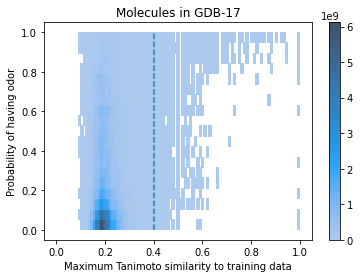

In [ ]:
ax = sns.histplot(gdb_df, y='transport.ML.odor.probability', x='max_tanimoto', weights='Count', bins=(np.linspace(0, 1, 100), np.linspace(0, 1, 20)), cbar=True)
plt.title('Molecules in GDB-17')
plt.plot([0.4, 0.4], [0, 1], '--')
plt.xlabel('Maximum Tanimoto similarity to training data')
plt.ylabel('Probability of having odor')

/export/hda3/borglet/remote_hdd_fs_dirs/0.brianklee_osmos_kernel.kernel.brianklee.706840287074.14b334fb3717c109/mount/server/colab.par:5: FutureWarning: This dataframe has a column name that matches the 'value_name' column name of the resultiing Dataframe. In the future this will raise an error, please set the 'value_name' parameter of DataFrame.melt to a unique name.


Text(0.5, 0, 'Cumulative probability of odor')

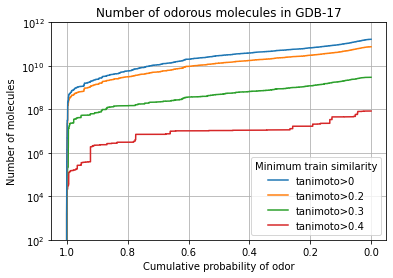

In [ ]:
legend_name = "Minimum train similarity"
gdb_with_tanimoto = gdb_df.copy()
for threshold in (0, 0.2, 0.3, 0.4):
  gdb_with_tanimoto['tanimoto>{}'.format(threshold)] = (gdb_df.max_tanimoto > threshold) * gdb_df.Count
melt_df = gdb_with_tanimoto.melt(id_vars='transport.ML.odor.probability', value_vars=['tanimoto>0', 'tanimoto>0.2', 'tanimoto>0.3', 'tanimoto>0.4'], var_name=legend_name, value_name='Count')
ax = sns.ecdfplot(data=melt_df, x="transport.ML.odor.probability", hue=legend_name, complementary=True, stat='count', weights='Count', log_scale=(False,True))
ax.invert_xaxis()
plt.grid(axis='both')
plt.ylim([1e2, 1e12])
plt.title('Number of odorous molecules in GDB-17')
plt.ylabel('Number of molecules')
plt.xlabel('Cumulative probability of odor')
